# Clustering Crypto

In [2]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import json

### Fetching Cryptocurrency Data

In [3]:
# Use the following endpoint to fetch json data
# url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [4]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
# url = url + "?format=json"
# requests.get(url)
# response_data = requests.get(url)
# data = response_data.json()
# json_data = pd

In [5]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")
file_path = Path("Resources/crypto_data.csv")
crypto_data = pd.read_csv(file_path, parse_dates=True, infer_datetime_format=True, index_col=0)
crypto_data.head(5)
# Create a DataFrame

CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
42     42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
365    365Coin       X11       True   PoW/PoS              NaN      2300000000
404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
611  SixEleven   SHA-256       True       PoW              NaN          611000
808        808   SHA-256       True   PoW/PoS     0.000000e+00               0

### Data Preprocessing

In [6]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
# crypto_data = crypto_data.drop(axis=1)

In [7]:
# Keep only cryptocurrencies that are trading
crypto_data = crypto_data[crypto_data['IsTrading'] == True]
crypto_data.head()

CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
42     42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
365    365Coin       X11       True   PoW/PoS              NaN      2300000000
404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
611  SixEleven   SHA-256       True       PoW              NaN          611000
808        808   SHA-256       True   PoW/PoS     0.000000e+00               0

In [8]:
# Keep only cryptocurrencies with a working algorithm
crypto_data = crypto_data[crypto_data['Algorithm'] != "N/A"]
crypto_data.head()

CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
42     42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
365    365Coin       X11       True   PoW/PoS              NaN      2300000000
404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
611  SixEleven   SHA-256       True       PoW              NaN          611000
808        808   SHA-256       True   PoW/PoS     0.000000e+00               0

In [9]:
# Remove the "IsTrading" column
crypto_data.drop(['IsTrading'], 1, inplace=True)
crypto_data.head()

CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42     42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
365    365Coin       X11   PoW/PoS              NaN      2300000000
404    404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
611  SixEleven   SHA-256       PoW              NaN          611000
808        808   SHA-256   PoW/PoS     0.000000e+00               0

In [10]:
# Remove rows with at least 1 null value
crypto_data.dropna(axis=0, how='any', inplace=True)
crypto_data.head()

CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42      42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
404     404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
808         808   SHA-256   PoW/PoS     0.000000e+00               0
1337  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
BTC     Bitcoin   SHA-256       PoW     1.792718e+07        21000000

In [11]:
# Remove rows with cryptocurrencies having no coins mined
crypto_data = crypto_data[crypto_data['TotalCoinsMined'] > 0]
crypto_data.head()

CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42      42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
404     404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
1337  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
BTC     Bitcoin   SHA-256       PoW     1.792718e+07        21000000
ETH    Ethereum    Ethash       PoW     1.076842e+08               0

In [12]:
# Drop rows where there are 'N/A' text values
crypto_data = crypto_data[crypto_data.iloc[:]!='N/A'].dropna()
crypto_data.head()

CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42      42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
404     404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
1337  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
BTC     Bitcoin   SHA-256       PoW     1.792718e+07        21000000
ETH    Ethereum    Ethash       PoW     1.076842e+08               0

In [13]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = pd.DataFrame(crypto_data["CoinName"])
coin_name.head()

CoinName
42      42 Coin
404     404Coin
1337  EliteCoin
BTC     Bitcoin
ETH    Ethereum

In [14]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_data.drop(['CoinName'], 1, inplace=True)
crypto_data.head()

Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42      Scrypt   PoW/PoS     4.199995e+01              42
404     Scrypt   PoW/PoS     1.055185e+09       532000000
1337       X13   PoW/PoS     2.927942e+10    314159265359
BTC    SHA-256       PoW     1.792718e+07        21000000
ETH     Ethash       PoW     1.076842e+08               0

In [15]:
# Create dummy variables for text features
X = pd.get_dummies(data = crypto_data, columns=['Algorithm', 'ProofType'])
X.head()

TotalCoinsMined TotalCoinSupply  Algorithm_1GB AES Pattern Search  \
42       4.199995e+01              42                                 0   
404      1.055185e+09       532000000                                 0   
1337     2.927942e+10    314159265359                                 0   
BTC      1.792718e+07        21000000                                 0   
ETH      1.076842e+08               0                                 0   

      Algorithm_536  Algorithm_Argon2d  Algorithm_BLAKE256  Algorithm_Blake  \
42                0                  0                   0                0   
404               0                  0                   0                0   
1337              0                  0                   0                0   
BTC               0                  0                   0                0   
ETH               0                  0                   0                0   

      Algorithm_Blake2S  Algorithm_Blake2b  Algorithm_C11  ...  \
42                    0                  0              0  ...   
404                   0                  0              0  ...   
1337                  0                  0              0  ...   
BTC                   0                  0              0  ...   
ETH                   0                  0              0  ...   

      ProofType_PoW/PoS  ProofType_PoW/PoS   ProofType_PoW/PoW  \
42                    1                   0                  0   
404                   1                   0                  0   
1337                  1                   0                  0   
BTC                   0                   0                  0   
ETH                   0                   0                  0   

      ProofType_PoW/nPoS  ProofType_Pos  ProofType_Proof of Authority  \
42                     0              0                             0   
404                    0              0                             0   
1337                   0              0                             0   
BTC                    0              0                             0   
ETH                    0              0                             0   

      ProofType_Proof of Trust  ProofType_TPoS  \
42                           0               0   
404                          0               0   
1337                         0               0   
BTC                          0               0   
ETH                          0               0   

      ProofType_Zero-Knowledge Proof  ProofType_dPoW/PoW  
42                                 0                   0  
404                                0                   0  
1337                               0                   0  
BTC                                0                   0  
ETH                                0                   0  

[5 rows x 98 columns]

In [16]:
# Standardize data
X = StandardScaler().fit_transform(X)
X[:1]

array([[-0.11710817, -0.1528703 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.06142951, -0.07530656, -0.0433963 , -0.06142951, -0.06142951,
        -0.0433963 , -0.0433963 , -0.19245009, -0.06142951, -0.09740465,
        -0.0433963 , -0.11547005, -0.07530656, -0.0433963 , -0.0433963 ,
        -0.15191091, -0.0433963 , -0.13118084, -0.0433963 , -0.0433963 ,
        -0.08703883, -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.06142951, -0.0433963 , -0.08703883, -0.08703883, -0.08703883,
        -0.0433963 , -0.13118084, -0.13840913, -0.13840913, -0.0433963 ,
        -0.06142951, -0.0433963 , -0.07530656, -0.18168574, -0.0433963 ,
        -0.0433963 , -0.0433963 , -0.07530656, -0.15826614, -0.31491833,
        -0.0433963 , -0.08703883, -0.07530656, -0.06142951,  1.38675049,
        -0.0433963 , -0.0433963 , -0.06142951, -0.0433963 , -0.0433963 ,
        -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.0433963 , -0.39879994, -0.0433963 , -0.1

### Reducing Dimensions Using PCA

In [17]:
# Use PCA to reduce dimensions to 3 principal components
crypto_data_pca = PCA(n_components=3)

crypto_data_pca = crypto_data_pca.fit_transform(X)

In [18]:
# Create a DataFrame with the principal components data
crypto_data_pca = pd.DataFrame(
    data=crypto_data_pca , columns=["PC1", "PC2", "PC3" ], index = crypto_data.index
)
crypto_data_pca.head()

PC1       PC2       PC3
42   -0.328184  1.041670 -0.594907
404  -0.311510  1.042029 -0.595327
1337  2.316165  1.719616 -0.654743
BTC  -0.133656 -1.265543  0.235809
ETH  -0.124774 -2.072037  0.415804

### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [19]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_data_pca)
    inertia.append(km.inertia_)


# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

C:\Users\vince\anaconda3\envs\pyviz_env\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [89]:
# Initialize the K-Means model
model = KMeans(n_clusters=3, random_state=5)
# Fit the model
model.fit(crypto_data_pca)
# Predict clusters
predictions = model.predict(crypto_data_pca)
print(predictions)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
crypto_data_pca["labels"] = model.labels_
crypto_data_pca.head()
labels_df = pd.DataFrame(crypto_data_pca["labels"])
labels_df

[1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1
 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1
 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0
 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1
 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1
 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0
 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0
 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 0 1 0 1 

labels
42         1
404        1
1337       1
BTC        0
ETH        0
...      ...
ZEPH       1
GAP        1
BDX        0
ZEN        0
XBC        1

[532 rows x 1 columns]

### Visualizing Results

#### 3D-Scatter with Clusters

In [94]:

clustered_df = pd.merge(crypto_data, crypto_data_pca, how="outer", left_index=True, right_index=True)
clustered_df
clustered_df2 = pd.merge(clustered_df, coin_name, how="outer", left_index=True, right_index=True)
clustered_df2


Algorithm ProofType  TotalCoinsMined TotalCoinSupply       PC1  \
42         Scrypt   PoW/PoS     4.199995e+01              42 -0.328184   
404        Scrypt   PoW/PoS     1.055185e+09       532000000 -0.311510   
1337          X13   PoW/PoS     2.927942e+10    314159265359  2.316165   
BTC       SHA-256       PoW     1.792718e+07        21000000 -0.133656   
ETH        Ethash       PoW     1.076842e+08               0 -0.124774   
...           ...       ...              ...             ...       ...   
ZEPH      SHA-256      DPoS     2.000000e+09      2000000000  2.431893   
GAP        Scrypt   PoW/PoS     1.493105e+07       250000000 -0.326226   
BDX   CryptoNight       PoW     9.802226e+08      1400222610  0.359798   
ZEN      Equihash       PoW     7.296538e+06        21000000 -0.177654   
XBC        Scrypt       PoS     1.283270e+05         1000000 -0.319486   

           PC2       PC3  labels     CoinName  
42    1.041670 -0.594907       1      42 Coin  
404   1.042029 -0.595327       1      404Coin  
1337  1.719616 -0.654743       1    EliteCoin  
BTC  -1.265543  0.235809       0      Bitcoin  
ETH  -2.072037  0.415804       0     Ethereum  
...        ...       ...     ...          ...  
ZEPH  0.658821  0.036339       1       ZEPHYR  
GAP   1.041576 -0.594932       1      Gapcoin  
BDX  -2.289133  0.471657       0       Beldex  
ZEN  -1.917510  0.302911       0      Horizen  
XBC   0.715787 -0.272856       1  BitcoinPlus  

[532 rows x 9 columns]

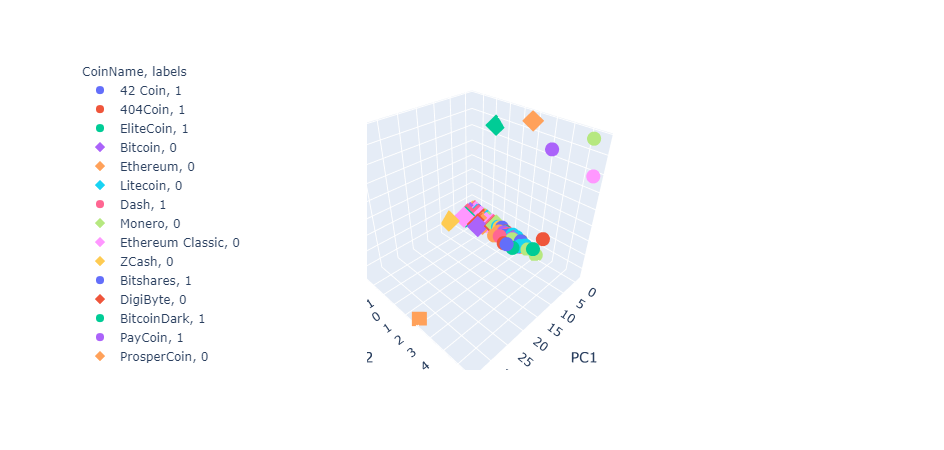

In [96]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
     clustered_df2,
    x="PC1",
    y="PC2",
    z="PC3",
    color="CoinName",
    symbol="labels",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [111]:
# Table with tradable cryptos
clustered_df2.hvplot.table(columns=["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "labels"], sortable=True, selectable=True)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,labels]

In [112]:
# Print the total number of tradable cryptocurrencies
print(clustered_df2)

        Algorithm ProofType  TotalCoinsMined TotalCoinSupply       PC1  \
42         Scrypt   PoW/PoS     4.199995e+01              42 -0.328184   
404        Scrypt   PoW/PoS     1.055185e+09       532000000 -0.311510   
1337          X13   PoW/PoS     2.927942e+10    314159265359  2.316165   
BTC       SHA-256       PoW     1.792718e+07        21000000 -0.133656   
ETH        Ethash       PoW     1.076842e+08               0 -0.124774   
...           ...       ...              ...             ...       ...   
ZEPH      SHA-256      DPoS     2.000000e+09      2000000000  2.431893   
GAP        Scrypt   PoW/PoS     1.493105e+07       250000000 -0.326226   
BDX   CryptoNight       PoW     9.802226e+08      1400222610  0.359798   
ZEN      Equihash       PoW     7.296538e+06        21000000 -0.177654   
XBC        Scrypt       PoS     1.283270e+05         1000000 -0.319486   

           PC2       PC3  labels     CoinName  
42    1.041670 -0.594907       1      42 Coin  
404   1.042029 

#### Scatter Plot with Tradable Cryptocurrencies

In [101]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df2.hvplot.scatter(
    x="TotalCoinsMined",
    y="TotalCoinSupply",
    hover_cols=["CoinName"],
    by="CoinName"
)


:NdOverlay   [CoinName]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)

In [110]:
clustered_df2.hvplot.scatter(x='TotalCoinsMined', y='TotalCoinSupply', hover_cols=["CoinName"],
    by="CoinName", xlim=(1, 100000000), ylim=(1, 10000000000))

:NdOverlay   [CoinName]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)